# Monografía Final
## Redes Neuronales - FIUBA
### Alumno: Julián Stejman

En este documento se utilizará una red neuronal entrenada con un algoritmo de aprendizaje por refuerzo que aprendiese a jugar niveles de Super Mario Bros para la NES. Para ello, se utilizará el entorno de OpenAI Gym, que simula el juego de Super Mario Bros.

In [10]:
%pip install gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import torch
import torch.nn as nn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

Si se eliminara en la siguiente celda la línea que dice %%skip, se podría ver una simulación simple de como funciona el emulador del juego con el entorno. 

In [12]:

%%skip
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

La idea sería armar una red neuronal convolucional para poder interpretar de las imágenes recibidas una posible acción para que tomara el personaje del juego. Esta red luego utilizará un algoritmo de aprendizaje por refuerzo para poder mejorar su desempeño.

En rigor, la salida no es una acción directamente sino lo que se llaman Q-valores, que le generan un puntaje de calidad a cada acción a tomar. Mientras más alto el puntaje más viable sería la acción en el momento.

In [13]:
class DQNetwork(nn.Module):
    def __init__(self,input_shape,num_actions):
        super().__init__()

        #Capas convolucionales
        self.image_processing = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride =1),
            nn.ReLU()
        )
        # Capas lineales para predicción de Q-valores
        self.fc = nn.Sequential(
            nn.Linear(self._image_processing_output_size(input_shape),512),
            nn.ReLU(),
            nn.Linear(512,num_actions)
        )
        # función que genera el tamaño de salida para la etapa lineal 
    def _image_processing_output_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output=self.image_processing(dummy_input)
            return int(torch.flatten(output, start_dim = 1).size(1))
        
    def forward(self,x):
        x = self.image_processing(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [14]:
frame_stack_count = 4
dimensions = 84
input_shape = (frame_stack_count,dimensions,dimensions)
num_actions = len(SIMPLE_MOVEMENT)

test_model = DQNetwork(input_shape, num_actions)
dummy_state = torch.zeros(1, *input_shape)
output = test_model(dummy_state)
print(output)


tensor([[ 0.0360, -0.0259, -0.0259, -0.0205,  0.0254, -0.0104,  0.0029]],
       grad_fn=<AddmmBackward0>)


Para enviar a la red, se toma la decisión de mandar los colores a blanco y negro,bajarle la resolución a 84x84 que es la que se suele utilizar para este tipo de ensayos, y de devolver en cada estado 4 cuadros. De esta forma la red podrá aprender en cada estado con más información del entorno y menos en definición visual

/home/julian/.pyenv/versions/Monografia/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


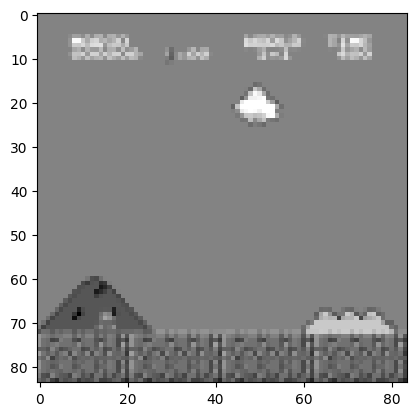

In [15]:
import gym
from gym.wrappers import GrayScaleObservation, FrameStack, ResizeObservation

# Create the Super Mario environment
env = gym.make('SuperMarioBros-v0')

# Apply the wrappers for preprocessing
env = GrayScaleObservation(env, keep_dim=True)  # Convert to grayscale (removes color channels)
env = ResizeObservation(env, shape=(dimensions,dimensions))     # Resize to 84x84
env = FrameStack(env, num_stack=frame_stack_count)               # Stack 4 frames

# Reset the environment to start
state = env.reset()

# Visualize the preprocessed frame (optional)
import matplotlib.pyplot as plt
plt.imshow(state[0], cmap='gray')  # Show the first frame in the stack
plt.show()


Para poder guardar los resultados de cada estado, se utiliza un replay buffer que simplemente guarda los resultados para ver cómo repercuten las acciones que toma la red.

In [16]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self,capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self,state,action,reward,next_state,done):
        self.buffer.append((state,action,reward,next_state,done))
    def sample(self,batch_size):
        return random.sample(self.buffer,batch_size)
    def size(self):
        return len(self.buffer)

Para entrenar a la red hay que tomar varias consideraciones. 
Inicialmente se propone un criterio de decisión que se llama epsilon-greedy que lo que hace es ir disminuyendo las opciones elegidas al azar al paso del tiempo. El enfoque de esto es para proponer una solución al asunto de "explorar vs explotar" donde un jugador podría maximizar su "premio" y no necesariamente buscar un camino más fructífero pero a la vez explorar mucho podría llegar a no maximizar nada. 

El algoritmo DQN se basa principalmente en maximizar la función de Bellman que tiene la siguiente forma
$$Q(s,a) = r + \gamma \cdot max_{a'} Q(s', a') $$
Donde r son los premios, $\gamma$ un factor escalar y los pares (s,a) y (s',a') siendo el par de estado-acción actual y futuro.

In [ ]:
from torch import optim
import numpy as np
def trainDQN(env, policy_network, target_network, replay_buffer, num_episodes=10,  # Reduce number of episodes for testing
             batch_size=64, gamma=0.99, learning_rate=1e-4, target_update_freq=1000, 
             epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.01,
             num_stack=4, width=84, height=84, render=False, device="cpu"):
    policy_network.to(device)
    target_network.to(device)
    optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    epsilon = epsilon_start
    steps = 0
    total_rewards = []

    for episode in range(1, num_episodes + 1):
        print(f"Starting episode {episode}")
        state = env.reset()
        state = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0).to(device)  # Se agrega una dimensión de batch
        episode_reward = 0
        done = False

        while not done:
            # Estrategia ε-greedy 
            if random.random() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                with torch.no_grad():
                    q_values = policy_network(state.squeeze(-1))
                    action = torch.argmax(q_values).item()  # Exploit

            # Execute action in environment
            next_state, reward, done, info = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
            episode_reward += reward

            # Store transition in replay buffer
            replay_buffer.push(state.cpu(), action, reward, next_state.cpu(), done)

            # Update state
            state = next_state

            # Print replay buffer size
            #print(f"Replay buffer size: {replay_buffer.size()}")
            

            # Print info to understand why the episode ended
            if done:
                print(f"Episode ended: {info}")
                break  # Break out of the loop to start a new episode

            # Train the policy network if we have enough samples
            if replay_buffer.size() >= batch_size:
                #print("Training the policy network")
                # Sample a batch of transitions
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert to tensors
                states = torch.cat(states).view(batch_size, num_stack, width, height).to(device)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.cat(next_states).view(batch_size, num_stack, width, height).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                # Compute current Q-values
                q_values = policy_network(states).gather(1, actions)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_network(next_states).max(1, keepdim=True)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                # Compute loss
                loss = loss_fn(q_values, target_q_values)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network periodically
            steps += 1
            if steps % target_update_freq == 0:
                print(f"Time: {info['time']}, Lives: {info['life']}")
                print("Updating target network")
                target_network.load_state_dict(policy_network.state_dict())

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Log episode results
        total_rewards.append(episode_reward)
        print(f"Episode {episode} finished, Reward: {episode_reward}, Epsilon: {epsilon:.3f}")

    env.close()
    return total_rewards

Para el algoritmo de entrenamiento DQN se utilizan 2 modelos en simultáneo, una red llamada la red de políticas, que es la que activamente está aprendiendo y se utiliza para seleccionar acciones durante el juego, y la red objetivo, que recibe menos actualizaciones pero es más estable. Esta última además se utiliza para el cálculo de Q-valores. 

In [ ]:
import pickle
# Guardar el estado local para continuar el entrenamiento
def save_training_state(filename, policy_network, target_network, buffer, total_rewards):
    state = {
        'policy_network': policy_network.state_dict(),
        'target_network': target_network.state_dict(),
        'replay_buffer': buffer.buffer,
        'total_rewards': total_rewards
    }
    with open(filename, 'wb') as f:
        pickle.dump(state, f)

def load_training_state(filename, policy_network, target_network, buffer):
    with open(filename, 'rb') as f:
        state = pickle.load(f)
    policy_network.load_state_dict(state['policy_network'])
    target_network.load_state_dict(state['target_network'])
    buffer.buffer = state['replay_buffer']
    return state['total_rewards']
    

# Ejemplo de uso:
# save_training_state('mario_dqn_state.pkl', policy_network, target_network, buffer, total_rewards)
# total_rewards = load_training_state('mario_dqn_state.pkl', policy_network, target_network, buffer)

In [ ]:
import numpy as np
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import os

# Se genera el entorno de juego 
width = 84
height = 84
num_stack = 4
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, RIGHT_ONLY)
env = GrayScaleObservation(env, keep_dim=True) 
env = ResizeObservation(env, shape=(width,height))     
env = FrameStack(env, num_stack)   

# Inicializo redes
input_shape = (num_stack, width, height)
num_actions = env.action_space.n
policy_network = DQNetwork(input_shape, num_actions)
target_network = DQNetwork(input_shape, num_actions)
target_network.load_state_dict(policy_network.state_dict())
target_network.eval()

# Creo el buffer
buffer = ReplayBuffer(10000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if os.path.exists('mario_dqn_state.pkl'):
    total_rewards = load_training_state('mario_dqn_state.pkl', policy_network, target_network, buffer)
else:
    total_rewards = []
more_rewards = trainDQN(
        env=env,
        policy_network=policy_network,
        target_network=target_network,
        replay_buffer=buffer,
        width=width,
        height=height,
        num_stack=num_stack,
        num_episodes=1,  # Number of additional episodes to train
        render=False,
        device=device
    )
save_training_state('mario_dqn_state.pkl', policy_network, target_network, buffer, total_rewards + more_rewards)
# Ejemplo de uso:
# total_rewards = load_training_state('mario_dqn_state.pkl', policy_network, target_network, buffer)

cpu
Starting episode 1
Time: 358, Lives: 1
Updating target network
Time: 308, Lives: 1
Updating target network


In [ ]:
%%skip 
state = torch.tensor(env.reset(), dtype=torch.float32).squeeze(-1).unsqueeze(0)
state.shape
policy_network(state)